# Data Cleaning & Visualization Exercise

### Kevin Byrnes
### 6/15/2023

In [1]:
# Import modules and data

# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None #takes care of a warning when assigning a new value to a slice.

# set parameters
trim_tol = 5 #anything above this many standard deviations from the row mean (by column type) set to nan.
my_tol = .9995 # to detect duplicated data
corr_tol = .9 #to detect erroneous data
winsor_level = .02 #for winsorization, to be implemented


# Load the data and look at columns for overview
my_str = '.\Quant_Exercise.csv'
df_1 = pd.read_csv(my_str)
df_1.head(20) #take an initial look at the data

# For future reference, note that column 2 (assuming we start with col 0) seems to replicate
# column 0, but is a float.
# Last 3 columns are identifying information (county or state, FIPS code).

,DP03_0001E,DP03_0001M,DP03_0001PE,DP03_0001PM,DP03_0002E,DP03_0002M,DP03_0002PE,DP03_0002PM,DP03_0003E,DP03_0003M,...,DP03_0136M,DP03_0136PE,DP03_0136PM,DP03_0137E,DP03_0137M,DP03_0137PE,DP03_0137PM,GEO_ID,county,fips
0,84387,137,84387.0,NaN,53245.0,910,63.1,1.1,53200,911,...,NaN,6.2,0.8,NaN,NaN,17.4,1.8,0500000US42001,Adams,42001.0
1,1015608,631,1015608.0,NaN,660484.0,3044,65.0,0.3,659555,3038,...,NaN,7.7,0.4,NaN,NaN,21.3,0.7,0500000US42003,Allegheny,42003.0
2,54444,101,54444.0,NaN,31615.0,519,58.1,1.0,31593,518,...,NaN,8.4,1.1,NaN,NaN,23.8,2.2,0500000US42005,Armstrong,42005.0
3,136682,202,136682.0,NaN,84153.0,1035,61.6,0.7,84051,1040,...,NaN,6.8,0.7,NaN,NaN,20.8,1.3,0500000US42007,Beaver,42007.0
4,40064,86,40064.0,NaN,23144.0,447,57.8,1.1,23140,447,...,NaN,8.0,1.2,NaN,NaN,25.0,3.2,0500000US42009,Bedford,42009.0
5,336742,481,336742.0,NaN,NaN,1692,65.0,0.5,218539,1687,...,NaN,9.6,0.6,NaN,NaN,21.4,1.3,0500000US42011,Berks,42011.0
6,100805,195,100805.0,NaN,59214.0,834,58.7,0.8,59117,837,...,NaN,10.0,1.2,NaN,NaN,27.0,2.0,0500000US42013,Blair,42013.0
7,48998,113,48998.0,NaN,28057.0,461,57.3,1.0,28053,460,...,NaN,9.8,1.4,NaN,NaN,23.6,2.6,0500000US42015,Bradford,42015.0
8,516530,480,517000.0,NaN,347974.0,2290,67.4,0.4,347540,2277,...,NaN,3.7,0.4,NaN,NaN,16.2,1.0,0500000US42017,Bucks,42017.0
9,154734,235,154734.0,NaN,98274.0,1317,63.5,0.8,98124,1321,...,NaN,4.6,0.5,NaN,NaN,19.5,1.4,0500000US42019,Butler,42019.0


## Preliminary observations:
* There is a row for each county.
* Data appears to be of 4 types for each county: _E, _M, _PE, and _PM
* _E and _M appear to be counts (=int) while _PE and _PM appear to be floats (probably percentages)
* Some columns appear to be entirely nans.
* Sometimes _PX data duplicates the _X data.
* Data is numeric except for the last 3 columns.

### Assumptions
* If _X = _PX then _PX is erroneous data (to be replaced with NAN)
* The total of each '_E' column rows 0:n-1 should add up to row n (state sum).  This is probably population count.


In [2]:
# Preliminary data cleaning

# Drop duplicated rows (by values) or columns (by label)
# Remove duplicated rows
df_1=df_1.drop_duplicates()

# Remove duplicated columns based on name
df_1 = df_1.loc[:,~df_1.columns.duplicated()].copy()

# create 4 dataframes based on initial data
col_list_1 = []
col_list_2 = []
col_list_3 = []
col_list_4 = []

n_cols = df_1.shape[1]
col_names = list(df_1.columns.values)
non_num_cols = ['GEO_ID','county','fips'] #list of non-numeric columns
numeric_cols = [item for item in col_names if item not in non_num_cols] #list of numeric columns

for i in range(n_cols-3):
    if i%4 == 0:
        col_list_1.append(col_names[i])
    elif i%4 == 1:
        col_list_2.append(col_names[i])
    elif i%4 ==2:
        col_list_3.append(col_names[i])
    else:
        col_list_4.append(col_names[i])

df_e = df_1[col_list_1]
df_m = df_1[col_list_2]
df_pe = df_1[col_list_3]
df_pm = df_1[col_list_4]

df_e.head(20) #this will be a reference point for comparing with future cleaned versions.
            # of course we can easily change the dataframe displayed to compare the effect
            # on the other dataframes as well.    
        
# Note the nan in column DP03_0002E        

,DP03_0001E,DP03_0002E,DP03_0003E,DP03_0004E,DP03_0005E,DP03_0006E,DP03_0007E,DP03_0008E,DP03_0009E,DP03_0010E,...,DP03_0128E,DP03_0129E,DP03_0130E,DP03_0131E,DP03_0132E,DP03_0133E,DP03_0134E,DP03_0135E,DP03_0136E,DP03_0137E
0,84387,53245.0,53200,51151,2049,45,31142,53200,NaN,43268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1015608,660484.0,659555,627514,32041,929,355124,659555,NaN,530120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,54444,31615.0,31593,29858,1735,22,22829,31593,NaN,27500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,136682,84153.0,84051,79802,4249,102,52529,84051,NaN,71048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40064,23144.0,23140,22107,1033,4,16920,23140,NaN,20389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,336742,NaN,218539,206343,12196,215,117988,218539,NaN,172897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100805,59214.0,59117,56352,2765,97,41591,59117,NaN,52004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,48998,28057.0,28053,26722,1331,4,20941,28053,NaN,24816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,516530,347974.0,347540,333063,14477,434,168556,347540,NaN,265341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,154734,98274.0,98124,93626,4498,150,56460,98124,NaN,78626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Another view of the data
X = df_e.iloc[:,20:30]
X.head()

# The column DP03_0025E is suspect, it's a float.

,DP03_0021E,DP03_0022E,DP03_0023E,DP03_0024E,DP03_0025E,DP03_0026E,DP03_0027E,DP03_0028E,DP03_0029E,DP03_0030E
0,185,1600,408,3040,28.9,51151,16051,8642,10146,5893
1,54648,24176,9175,52937,26.9,627514,299507,101153,134480,36559
2,95,673,355,1440,30.0,29858,8387,5629,5537,3883
3,1587,1701,881,4369,26.4,79802,29157,13824,17327,7543
4,113,550,197,1188,26.0,22107,6447,3886,4292,2813


## Exploratory data analysis
Check the correlation between data columns in entire numeric dataset, and within each type of column label.
Notice that:
* Correlations are very high for '_E' and '_M' data, so these are probably relatively stable level variables.
* Data is either all present or entirely nan (by column) (with one exception).
* So we can detect errors by looking for columns where the correlation with the first column's data is very low.
* We can also reasonably impute missing columns by filling with the median (by row of the same 'type') after removing erroneous data.


Based on the master correlation matrix, we also notice that '_PE' and '_PM' columns have relatively low correlations to other columns and within their own 'type', so these are probably change variables.
* Thus if we notice an exceedingly high correlation to another column (e.g. '_PE' and '_E'), we can assume this is a data error.


Note that we can (and did!) spot check these assumptions by investigating pairs of columns with suspiciously high or low correlations in the raw data.


In [4]:
# Exploratory data analysis

#Check correlations
df_2 = df_1[numeric_cols] #Assuming only last 3 columns are non-numeric (from data inspection)
corr_mtx = df_2.corr(numeric_only=False) #after checking data types found 
                                         #that they are not natively numeric format, so need to convert.
    
corr_mtx_e = df_e.corr(numeric_only=False)
corr_mtx_m = df_m.corr(numeric_only=False)
corr_mtx_pe = df_pe.corr(numeric_only=False)
corr_mtx_pm = df_pm.corr(numeric_only=False)

# Summary statistics by column label
# Transpose since we need statistics by row.
# We see that std is low for df_e and df_m, so relatively safe to impute with row median.
stats_e = df_e.T.describe()
stats_m = df_m.T.describe()
stats_pe = df_pe.T.describe()
stats_pm = df_pm.T.describe()

# The preceding summary statistics (by row) will prove to be more useful, but assuming no 
# knowledge of the data we should also look at the summary statistics by column.
# In particular, we can look at the dimension along which data has lower variance (for future
# data imputation).

stats_eT = df_e.describe()
stats_mT = df_m.describe()
stats_peT = df_pe.describe()
stats_pmT = df_pm.describe()

stats_e.head(20)
#stats_eT.head(20)

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,117.000000,1.170000e+02,117.000000,117.000000,117.000000,116.000000,117.000000,117.000000,117.000000,117.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,1.170000e+02
mean,20810.212821,1.876394e+05,14428.991453,29625.456410,11634.102564,64459.304310,22430.185470,13460.117949,100976.165812,34239.490598,...,10592.632479,11262.974359,12083.906838,10662.475214,36088.193162,12009.167521,56778.307692,9504.196581,70935.335043,1.829044e+06
std,25612.206718,2.640457e+05,18472.697687,35761.942245,16094.246039,85500.054111,26748.627695,17611.902613,136697.182293,41999.425784,...,15524.941024,18426.623928,16291.811765,15883.579776,44406.184946,17240.951779,73805.864943,17221.529197,94039.023504,2.691367e+06
min,28.900000,2.690000e+01,22.000000,26.400000,4.000000,25.300000,20.700000,4.000000,30.400000,27.400000,...,6.000000,6.000000,10.000000,4.000000,26.600000,12.000000,27.000000,6.000000,27.200000,2.710000e+01
25%,2329.000000,2.875700e+04,1586.000000,3839.000000,1082.000000,9832.250000,2769.000000,1331.000000,13658.000000,4498.000000,...,990.000000,930.000000,1275.000000,828.000000,5350.000000,1104.000000,8377.000000,573.000000,11242.000000,1.625090e+05
50%,7462.000000,5.600000e+04,4416.000000,10035.000000,3125.000000,23880.000000,8309.000000,4027.000000,36298.000000,11559.000000,...,2768.000000,2323.000000,3941.000000,2484.000000,11616.000000,2974.000000,21294.000000,1876.000000,26253.000000,5.015800e+05
75%,36502.000000,2.435940e+05,25790.000000,52305.000000,19930.000000,89626.750000,40799.000000,22386.000000,140848.000000,56809.000000,...,16442.000000,15668.000000,20070.000000,16366.000000,61639.000000,19917.000000,80393.000000,10980.000000,97354.000000,2.477901e+06
max,101374.000000,1.204972e+06,78308.000000,163315.000000,75618.000000,414332.000000,120977.000000,79536.000000,621805.000000,185707.000000,...,74965.000000,98777.000000,74725.000000,78014.000000,205197.000000,84253.000000,347565.000000,91576.000000,442441.000000,1.259064e+07


In [5]:
# Let's look at the correlation matrix
# Seems like '_E' and '_M' variables are highly correlated among their own types.
# Notice that the 3rd column of the data seems to replicate the first column, as we saw from the 
# data view earlier.

corr_mtx.head(20)

,DP03_0001E,DP03_0001M,DP03_0001PE,DP03_0001PM,DP03_0002E,DP03_0002M,DP03_0002PE,DP03_0002PM,DP03_0003E,DP03_0003M,...,DP03_0135PE,DP03_0135PM,DP03_0136E,DP03_0136M,DP03_0136PE,DP03_0136PM,DP03_0137E,DP03_0137M,DP03_0137PE,DP03_0137PM
DP03_0001E,1.000000,0.889886,1.000000,NaN,0.999949,0.912772,0.147468,-0.270239,0.999948,0.911348,...,0.047058,-0.283805,NaN,NaN,0.020602,-0.270975,NaN,NaN,-0.042150,-0.294460
DP03_0001M,0.889886,1.000000,0.889888,NaN,0.894171,0.987334,0.357103,-0.482712,0.891655,0.987505,...,0.074416,-0.488808,NaN,NaN,0.052645,-0.476416,NaN,NaN,-0.140101,-0.528163
DP03_0001PE,1.000000,0.889888,1.000000,NaN,0.999949,0.912775,0.147475,-0.270245,0.999948,0.911351,...,0.047051,-0.283811,NaN,NaN,0.020592,-0.270981,NaN,NaN,-0.042158,-0.294466
DP03_0001PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0002E,0.999949,0.894171,0.999949,NaN,1.000000,0.914486,0.152971,-0.274241,1.000000,0.913080,...,0.042806,-0.288263,NaN,NaN,0.015154,-0.275574,NaN,NaN,-0.047230,-0.298496
DP03_0002M,0.912772,0.987334,0.912775,NaN,0.914486,1.000000,0.298497,-0.432418,0.913868,0.999971,...,0.102964,-0.448047,NaN,NaN,0.064754,-0.453145,NaN,NaN,-0.058226,-0.491602
DP03_0002PE,0.147468,0.357103,0.147475,NaN,0.152971,0.298497,1.000000,-0.799778,0.152389,0.300079,...,-0.330794,-0.622590,NaN,NaN,-0.350135,-0.677868,NaN,NaN,-0.393605,-0.597032
DP03_0002PM,-0.270239,-0.482712,-0.270245,NaN,-0.274241,-0.432418,-0.799778,1.000000,-0.272977,-0.434040,...,0.191420,0.837614,NaN,NaN,0.206887,0.870164,NaN,NaN,0.262753,0.865584
DP03_0003E,0.999948,0.891655,0.999948,NaN,1.000000,0.913868,0.152389,-0.272977,1.000000,0.912468,...,0.042706,-0.287041,NaN,NaN,0.015318,-0.274178,NaN,NaN,-0.047348,-0.297229
DP03_0003M,0.911348,0.987505,0.911351,NaN,0.913080,0.999971,0.300079,-0.434040,0.912468,1.000000,...,0.101832,-0.450152,NaN,NaN,0.064192,-0.454862,NaN,NaN,-0.059371,-0.493495


In [6]:
# Taking a finer look at the correlation within these types we see that there are some breakdowns in
# correlations.  These seem to match the observations we made earlier. 

corr_mtx_e.head(20)

,DP03_0001E,DP03_0002E,DP03_0003E,DP03_0004E,DP03_0005E,DP03_0006E,DP03_0007E,DP03_0008E,DP03_0009E,DP03_0010E,...,DP03_0128E,DP03_0129E,DP03_0130E,DP03_0131E,DP03_0132E,DP03_0133E,DP03_0134E,DP03_0135E,DP03_0136E,DP03_0137E
DP03_0001E,1.000000,0.999949,0.999948,0.999915,0.996965,0.993641,0.999851,0.999948,NaN,0.999985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0002E,0.999949,1.000000,1.000000,0.999989,0.996629,0.993940,0.999628,1.000000,NaN,0.999935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0003E,0.999948,1.000000,1.000000,0.999989,0.996634,0.993903,0.999624,1.000000,NaN,0.999935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0004E,0.999915,0.999989,0.999989,1.000000,0.996239,0.994147,0.999554,0.999989,NaN,0.999882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0005E,0.996965,0.996629,0.996634,0.996239,1.000000,0.986091,0.997297,0.996634,NaN,0.997308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0006E,0.993641,0.993940,0.993903,0.994147,0.986091,1.000000,0.992939,0.993903,NaN,0.993405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0007E,0.999851,0.999628,0.999624,0.999554,0.997297,0.992939,1.000000,0.999624,NaN,0.999835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0008E,0.999948,1.000000,1.000000,0.999989,0.996634,0.993903,0.999624,1.000000,NaN,0.999935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0009E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP03_0010E,0.999985,0.999935,0.999935,0.999882,0.997308,0.993405,0.999835,0.999935,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

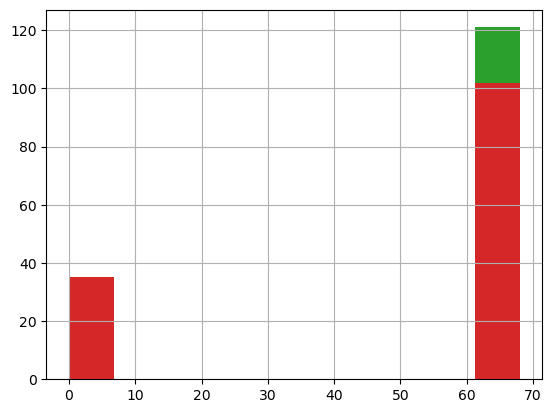

In [7]:
# What does the distribution of missing data look like?
# Based on the histograms below, data is (almost) always entirely missing or present by _column_
stats_eT.T['count'].hist(bins=10)  
stats_mT.T['count'].hist(bins=10)  
stats_peT.T['count'].hist(bins=10)  
stats_pmT.T['count'].hist(bins=10) 

# We can verify that there is only one column that is not all filled or all Nan.
#list_e = stats_e.T['count']
#list_m = stats_m.T['count']
#list_pe = stats_pe.T['count']
#list_pm = stats_pm.T['count']


In [8]:
# Detailed data cleaning
m_rows = df_e.shape[0]
m_cols = df_e.shape[1]

# z-score the data
# if any data values are > trim_tol sd from the mean (by row) of that data type, set to nan
for j in range(m_rows):
    zs_e = ((df_e.iloc[j,:]-stats_e.loc['mean',j])/stats_e.loc['std',j]).abs()
    zs_m = ((df_m.iloc[j,:]-stats_m.loc['mean',j])/stats_m.loc['std',j]).abs()
    zs_pe = ((df_pe.iloc[j,:]-stats_pe.loc['mean',j])/stats_pe.loc['std',j]).abs()
    zs_pm = ((df_pm.iloc[j,:]-stats_pm.loc['mean',j])/stats_pm.loc['std',j]).abs()
     
    tf_e = zs_e.to_numpy()>trim_tol    
    tf_m = zs_m.to_numpy()>trim_tol 
    tf_pe = zs_pe.to_numpy()>trim_tol 
    tf_pm = zs_pm.to_numpy()>trim_tol  
    
    df_e.iloc[j, tf_e]= np.nan
    df_m.iloc[j, tf_m]= np.nan
    df_pe.iloc[j, tf_pe]= np.nan
    df_pm.iloc[j, tf_pm]= np.nan

    
# if '_E' or '_M' column has relatively low correlation to first column of that type, 
# assume data is erroneous and set to nan
bad_cols_1 = []
bad_cols_2 = []

for i in range(m_cols):  
    z_1 = corr_mtx_e.iloc[0,i]
    z_2 = corr_mtx_m.iloc[0,i]
    
    if z_1 < corr_tol:
        bad_cols_1.append(col_list_1[i])
    
    if z_2 < corr_tol:
        bad_cols_2.append(col_list_2[i])

df_e.loc[:,bad_cols_1] = np.nan 
df_m.loc[:,bad_cols_2] = np.nan


# if _PE = _E for a given column index or _PM = _M, then set _PX to Nan
bad_cols_3 = []
bad_cols_4 = []

for i in range(m_cols):
    x_1 = df_e.iloc[:,i]
    y_1 = df_pe.iloc[:,i]
    z_1 = abs(x_1.corr(y_1))
    
    x_2 = df_m.iloc[:,i]
    y_2 = df_pm.iloc[:,i]
    z_2 = abs(x_2.corr(y_2))
    
    if z_1>my_tol:
        bad_cols_3.append(col_list_3[i])
    if z_2>my_tol:
        bad_cols_4.append(col_list_4[i])    
        
df_pe.loc[:,bad_cols_3] = np.nan 
df_pm.loc[:,bad_cols_4] = np.nan

print(df_e.loc[:,'DP03_0025E']) #let's verify that we caught the suspicious looking data in the DP03_0025E

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
63   NaN
64   NaN
65   NaN
66   NaN
67   NaN
Name: DP03_0025E, Length: 68, dtype: float64


C:\Users\drkev\anaconda3\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\drkev\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [9]:
df_e.head(20) #Check that not everything has been set to nan!

,DP03_0001E,DP03_0002E,DP03_0003E,DP03_0004E,DP03_0005E,DP03_0006E,DP03_0007E,DP03_0008E,DP03_0009E,DP03_0010E,...,DP03_0128E,DP03_0129E,DP03_0130E,DP03_0131E,DP03_0132E,DP03_0133E,DP03_0134E,DP03_0135E,DP03_0136E,DP03_0137E
0,84387,53245.0,53200,51151,2049,45,31142,53200,NaN,43268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1015608,660484.0,659555,627514,32041,929,355124,659555,NaN,530120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,54444,31615.0,31593,29858,1735,22,22829,31593,NaN,27500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,136682,84153.0,84051,79802,4249,102,52529,84051,NaN,71048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40064,23144.0,23140,22107,1033,4,16920,23140,NaN,20389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,336742,NaN,218539,206343,12196,215,117988,218539,NaN,172897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100805,59214.0,59117,56352,2765,97,41591,59117,NaN,52004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,48998,28057.0,28053,26722,1331,4,20941,28053,NaN,24816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,516530,347974.0,347540,333063,14477,434,168556,347540,NaN,265341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,154734,98274.0,98124,93626,4498,150,56460,98124,NaN,78626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Impute missing values

# only for _E data
# compute the sum of non-nan values and the count
z = df_e.iloc[list(range(m_rows-1)),:].copy()

for i in range(m_cols):
    state_sum = df_e.iloc[m_rows-1,i]
    this_sum = np.nansum(z.iloc[:,i])
    this_count = sum(z.iloc[:,i].isna())
    this_col = df_e.iloc[:,i]
    
    if ~np.isnan(this_sum) and ~np.isnan(state_sum) and this_count >0:
        fill_amt = (state_sum-this_sum)/this_count
        this_col.fillna(fill_amt)
        df_e.iloc[:,i].fillna(fill_amt, inplace=True)

        
# for nan columns, fill with median by row
med_e = df_e.median(axis=1)
med_m = df_m.median(axis=1)
med_pe = df_pe.median(axis=1)
med_pm = df_pm.median(axis=1)


for j in range(m_cols):
    df_e.iloc[:,j].fillna(med_e, inplace=True)
    df_m.iloc[:,j].fillna(med_m, inplace=True)
    df_pe.iloc[:,j].fillna(med_pe, inplace=True)
    df_pm.iloc[:,j].fillna(med_pm, inplace=True)
    
# we can also try ffill or bfill, if we know that the data is a sorted time series.

df_e.head(10) #example of nans filled with median

# The nan in DP03_0002E has been filled

,DP03_0001E,DP03_0002E,DP03_0003E,DP03_0004E,DP03_0005E,DP03_0006E,DP03_0007E,DP03_0008E,DP03_0009E,DP03_0010E,...,DP03_0128E,DP03_0129E,DP03_0130E,DP03_0131E,DP03_0132E,DP03_0133E,DP03_0134E,DP03_0135E,DP03_0136E,DP03_0137E
0,84387,53245.0,53200,51151,2049,45,31142,53200,5656.0,43268,...,5656.0,5656.0,5656.0,5656.0,5656.0,5656.0,5656.0,5656.0,5656.0,5656.0
1,1015608,660484.0,659555,627514,32041,929,355124,659555,59109.0,530120,...,59109.0,59109.0,59109.0,59109.0,59109.0,59109.0,59109.0,59109.0,59109.0,59109.0
2,54444,31615.0,31593,29858,1735,22,22829,31593,3663.0,27500,...,3663.0,3663.0,3663.0,3663.0,3663.0,3663.0,3663.0,3663.0,3663.0,3663.0
3,136682,84153.0,84051,79802,4249,102,52529,84051,9074.0,71048,...,9074.0,9074.0,9074.0,9074.0,9074.0,9074.0,9074.0,9074.0,9074.0,9074.0
4,40064,23144.0,23140,22107,1033,4,16920,23140,2799.0,20389,...,2799.0,2799.0,2799.0,2799.0,2799.0,2799.0,2799.0,2799.0,2799.0,2799.0
5,336742,218754.0,218539,206343,12196,215,117988,218539,21838.0,172897,...,21838.0,21838.0,21838.0,21838.0,21838.0,21838.0,21838.0,21838.0,21838.0,21838.0
6,100805,59214.0,59117,56352,2765,97,41591,59117,6685.0,52004,...,6685.0,6685.0,6685.0,6685.0,6685.0,6685.0,6685.0,6685.0,6685.0,6685.0
7,48998,28057.0,28053,26722,1331,4,20941,28053,3277.0,24816,...,3277.0,3277.0,3277.0,3277.0,3277.0,3277.0,3277.0,3277.0,3277.0,3277.0
8,516530,347974.0,347540,333063,14477,434,168556,347540,33445.0,265341,...,33445.0,33445.0,33445.0,33445.0,33445.0,33445.0,33445.0,33445.0,33445.0,33445.0
9,154734,98274.0,98124,93626,4498,150,56460,98124,9482.0,78626,...,9482.0,9482.0,9482.0,9482.0,9482.0,9482.0,9482.0,9482.0,9482.0,9482.0


In [11]:
print(df_e.loc[:,'DP03_0025E']) #These nans have also been filled with the median values.

0       5656.0
1      59109.0
2       3663.0
3       9074.0
4       2799.0
        ...   
63      2605.0
64     18635.0
65      1532.0
66     24245.0
67    670877.0
Name: DP03_0025E, Length: 68, dtype: float64


In [12]:
# The '_PE' and '_PM' datasets may be relative change datasets.
# Now that the '_E' and '_M' datasets have been cleaned, we can define the relative difference datasets.
# These may be a better way of imputing the data than the nan median.

# Create differenced datasets for possible future fill of '_PE' and '_PM' columns
x_e = df_e.iloc[:,0:m_cols-1]
y_e = df_e.iloc[:,1:m_cols] 

x_m = df_m.iloc[:,0:m_cols-1]
y_m = df_m.iloc[:,1:m_cols]  

#instantiate differenced datasets
df_de = x_e.copy()
df_dm = x_m.copy()

for i in range(m_cols-1):
    for j in range(m_rows):
        this_num_e = x_e.iloc[j,i]
        this_denom_e = y_e.iloc[j,i]
        
        this_num_m = x_m.iloc[j,i]
        this_denom_m = y_m.iloc[j,i]
        
        if abs(this_denom_e)>0:
            df_de.iloc[j,i]= (this_num_e/this_denom_e)-1
            
        if abs(this_denom_m)>0:
            df_dm.iloc[j,i]= (this_num_m/this_denom_m)-1    
        
# Correlation analysis with df_pe and df_pm
# to be implemented.        
        

In [13]:
# Write data back into original dataset and save

df_1.loc[:,col_list_1] = df_e.loc[:,col_list_1]
df_1.loc[:,col_list_2] = df_m.loc[:,col_list_2]
df_1.loc[:,col_list_3] = df_pe.loc[:,col_list_3]
df_1.loc[:,col_list_4] = df_pm.loc[:,col_list_4]

# Winsorize data
# to be implemented.

# Save to output dataset
df_1.to_csv('out.csv')

df_1.head(20) #Let's have a final look at the data.

C:\Users\drkev\AppData\Local\Temp\ipykernel_17944\445979170.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_1.loc[:,col_list_1] = df_e.loc[:,col_list_1]


,DP03_0001E,DP03_0001M,DP03_0001PE,DP03_0001PM,DP03_0002E,DP03_0002M,DP03_0002PE,DP03_0002PM,DP03_0003E,DP03_0003M,...,DP03_0136M,DP03_0136PE,DP03_0136PM,DP03_0137E,DP03_0137M,DP03_0137PE,DP03_0137PM,GEO_ID,county,fips
0,84387,137,10.60,1.0,53245.0,910,63.1,1.1,53200,911,...,410.0,6.2,0.8,5656.0,410.0,17.4,1.8,0500000US42001,Adams,42001.0
1,1015608,631,11.20,0.3,660484.0,3044,65.0,0.3,659555,3038,...,1797.0,7.7,0.4,59109.0,1797.0,21.3,0.7,0500000US42003,Allegheny,42003.0
2,54444,101,13.05,1.1,31615.0,519,58.1,1.0,31593,518,...,282.0,8.4,1.1,3663.0,282.0,23.8,2.2,0500000US42005,Armstrong,42005.0
3,136682,202,11.30,0.8,84153.0,1035,61.6,0.7,84051,1040,...,544.5,6.8,0.7,9074.0,544.5,20.8,1.3,0500000US42007,Beaver,42007.0
4,40064,86,12.50,1.3,23144.0,447,57.8,1.1,23140,447,...,263.5,8.0,1.2,2799.0,263.5,25.0,3.2,0500000US42009,Bedford,42009.0
5,336742,481,11.80,0.6,218754.0,1692,65.0,0.5,218539,1687,...,1000.5,9.6,0.6,21838.0,1000.5,21.4,1.3,0500000US42011,Berks,42011.0
6,100805,195,13.65,1.0,59214.0,834,58.7,0.8,59117,837,...,499.5,10.0,1.2,6685.0,499.5,27.0,2.0,0500000US42013,Blair,42013.0
7,48998,113,12.55,1.2,28057.0,461,57.3,1.0,28053,460,...,255.0,9.8,1.4,3277.0,255.0,23.6,2.6,0500000US42015,Bradford,42015.0
8,516530,480,8.40,0.5,347974.0,2290,67.4,0.4,347540,2277,...,1305.0,3.7,0.4,33445.0,1305.0,16.2,1.0,0500000US42017,Bucks,42017.0
9,154734,235,8.85,0.7,98274.0,1317,63.5,0.8,98124,1321,...,567.0,4.6,0.5,9482.0,567.0,19.5,1.4,0500000US42019,Butler,42019.0


## What I caught/observed:
1. How to impute missing rows of '_E' columns
2. '_E' and '_M' were ints (likely counts) and '_PE' and '_PM' were floats (possibly percent changes), so you could identify erroneous data from an incorrect type casting. In practice, since the distribution of these numbers was different, it was more efficient to do it via the correlation matrix.
3. Whenever '_PE' was equal to '_E', the following '_PM' column was missing.
4. Routine data cleaning based on outlier detection (z-scoring) and missing data imputation with nan medians.

## Things I would have liked to examine if I had more time:
1. Create a new dataframe that is (m_rows x m_cols) x 5, where the first 4 columns are stackings of    the current '_E', '_M', '_PE', and '_PM' columns, and the last column has a 'date' key derived from the original column names (e.g. first m_rows have a date that is derived from the column label of the first 4 columns, etc.)
Since it is fairly obvious that there are 4 longitudinal numeric data series, this is probably a better way to handle the data.

2. Look for k-period seasonality.

3. Examine correlation between the datasets df_de and df_pe.iloc[:,0:m_cols-1] (similarly for df_dm and df_pm).  
If there is a strong correlation, this would probably lead to a better way to impute missing values than filling with the nan median.
4. Implement winsorization.
5. Go back and vectorize any loops. 